In [0]:
`import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, LSTM

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data = pd.read_csv("drive/My Drive/JS_peaks1_5.csv", index_col= "DateTime")
data.index = pd.to_datetime(data.index)

In [0]:
# data["peaks"] = data.peaks.shift(-1)
# data = data[1:-2]

In [0]:
data.head()

,open,high,low,close,volume,sma5,sma10,sma20,emadiff,BB,stochrsifastk,stochrsifastd,ROC,TrueRange,MOM6,MOM12,WilliamR10,WilliamR16,ULOSC,RSI6,RSI12,stochfastkdiff,stochfastddiff,avgPrice,normPrice,sma5diff,sma20diff,smadiff,pricemadiff,peaks
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-02-03 09:15:00+05:30,1575.00,1581.70,1571.80,1578.90,794,1571.54,1572.210,1566.0175,4.200250,0.013187,100.000000,46.902661,1.211538,11.70,7.90,18.95,-18.122977,-11.222445,61.172725,77.018340,74.028403,59.292018,31.678691,0.005669,0.009075,0.001006,0.000764,0.004293,0.008226,0
2015-02-03 09:16:00+05:30,1578.90,1581.90,1577.75,1581.00,976,1573.62,1573.005,1567.3175,4.762186,0.013114,100.000000,80.235994,1.362398,4.15,10.00,16.05,-5.750799,-3.614458,67.537331,79.735119,75.993636,0.000000,33.333333,0.001330,0.010417,0.001324,0.000830,0.004855,0.008730,1
2015-02-03 09:17:00+05:30,1580.00,1580.00,1572.20,1574.45,1177,1574.31,1572.950,1568.2200,4.625673,0.010535,21.067118,73.689039,0.929517,8.80,3.85,5.45,-47.603834,-31.236897,59.435648,55.277099,60.433774,-78.932882,-6.546955,-0.004143,0.006231,0.000438,0.000576,0.004461,0.003973,-1
2015-02-03 09:18:00+05:30,1574.45,1577.95,1574.45,1577.00,759,1576.27,1573.215,1569.1725,4.669423,0.009586,20.127735,47.064951,0.769993,3.50,6.00,3.95,-31.309904,-20.545073,59.800593,60.882682,63.599165,-0.939383,-26.624088,0.001620,0.007861,0.001245,0.000607,0.005133,0.004988,0
2015-02-03 09:19:00+05:30,1577.00,1577.00,1575.05,1575.55,696,1577.38,1573.670,1570.0375,4.534818,0.009239,0.763096,13.985983,0.417463,1.95,8.35,0.55,-40.575080,-28.995434,56.864183,56.085863,60.592151,-19.364639,-33.078968,-0.000919,0.006934,0.000704,0.000551,0.005230,0.003511,0


In [0]:
df = data.drop(["high","low","open","volume"],axis=1)
#df.peaks.replace(-1,2,inplace=True)
#df = df.drop("volume",axis=1)
#df = df[-10250:]

In [0]:
df.peaks.replace(-1,2,inplace=True)

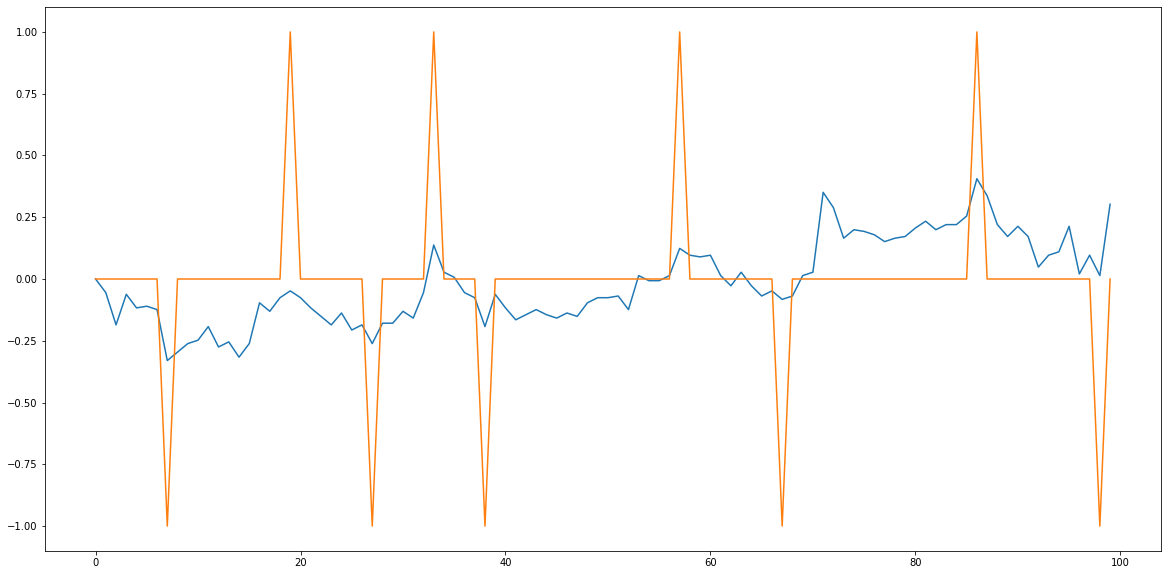

In [0]:
plt.figure(figsize=(20,10))
plt.plot(100*(df.close.values[-100:]/df.close.values[-100] - 1))
plt.plot(df.peaks.values[-100:])

In [0]:
## Make 10x29 image dataset
#peek_future = 2
impact = 0.00
buy = 0
sell = 0
idle = 0
look_back=3
# imagesXb = []
# imagesYb = []
# imagesXs = []
# imagesYs = []
imagesX = []
imagesY = []
dfX = df.drop("peaks",axis=1).values
peaks = df.peaks.values
for i in range(look_back,len(dfX)):
  if(peaks[i] == 1):
    imagesX.append(dfX[i-look_back:i+1])
    imagesY.append(peaks[i])
    sell += 1
    while(sell<=idle):
      imagesX.append(dfX[i-look_back:i+1])
      imagesY.append(peaks[i])
      sell += 1
  if(peaks[i] == 2):
    imagesX.append(dfX[i-look_back:i+1])
    imagesY.append(peaks[i])
    buy += 1
    while(buy<=idle):
      imagesX.append(dfX[i-look_back:i+1])
      imagesY.append(peaks[i])
      buy += 1
  else:
    imagesX.append(dfX[i-look_back:i+1])
    imagesY.append(peaks[i])
    idle += 1

  # if((df.values[i][3] + impact*df.values[i][3]) < max(df.values[i+1:i+peek_future,3])):
  #   #imagesXb.append(df.values[i-29:i])
  #   #imagesYb.append(0)
  #   imagesY.append(0)
  #   buy += 1
  # else:
  #   #imagesXs.append(df.values[i-29:i])
  #   #imagesYs.append(1)
  #   imagesY.append(1)
  #   sell += 1


In [0]:
print("Buy",buy)
print("Sell",sell)
print("Idle",idle)

Buy 404473
Sell 404461
Idle 404473


In [0]:
imagesX = np.array(imagesX)
imagesY = np.array(imagesY)
plt.figure(figsize=(20,10))
plt.plot(200*(imagesX[-100:,-1,3]/imagesX[-100,-1,3]-1))
plt.plot(imagesY[-100:])

In [0]:
# print("Buy:", buy)
# print("Sell:", sell)
np.array(imagesX).shape

(1213407, 2, 25)

In [0]:
batch_size = 64
num_classes = 3
epochs = 10

img_rows, img_cols = 4, 25
size = 1212000
input_shape = (img_rows, img_cols, 1)

#x_train1, x_test1, y_train1, y_test1 = train_test_split(imagesX, imagesY, train_size=0.9, shuffle=False, random_state=116)
x_train1 = imagesX[:size]
x_test1 = imagesX[size:]

y_train1 = imagesY[:size]
y_test1 = imagesY[size:]


x_train2, x_test2, y_train2, y_test2 = train_test_split(x_train1, y_train1, train_size=0.9, random_state=116)

x_train3 = np.array(x_train2)
x_train = x_train3.reshape(x_train3.shape[0], img_rows, img_cols, 1)

x_test3 = np.array(x_test2)
x_test = x_test3.reshape(x_test3.shape[0], img_rows, img_cols, 1)


y_train = keras.utils.to_categorical(y_train2, num_classes=num_classes)
y_test = keras.utils.to_categorical(y_test2, num_classes=num_classes)


In [0]:
model = Sequential()
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(Conv2D(256, (2,2), activation='relu'))
model.add(MaxPooling2D(pool_size=(1,1)))
model.add(Dropout(0.35))
model.add(Flatten())
#model.add(LSTM(50,activation='relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.50))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['categorical_accuracy'])

In [0]:
model.fit(x_train, y_train,
          batch_size=128, 
          epochs=2, 
          verbose=1,
          validation_data=(x_test, y_test))

Train on 1090800 samples, validate on 121200 samples
Epoch 1/2
1090800/1090800 [==============================] - 182s 166us/step - loss: 0.5245 - categorical_accuracy: 0.8399 - val_loss: 0.3313 - val_categorical_accuracy: 0.8712
Epoch 2/2
1090800/1090800 [==============================] - 185s 169us/step - loss: 0.3511 - categorical_accuracy: 0.8644 - val_loss: 0.3254 - val_categorical_accuracy: 0.8754


In [0]:
model.save("JSPeaks866_peek5.h5")

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 2, 25, 128)        256       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 25, 256)        33024     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 25, 256)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2, 25, 256)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1638528   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)              

In [0]:
score = model.evaluate(x_train, y_train, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1090800/1090800 [==============================] - 96s 88us/step
Test loss: 0.3168405575233368
Test accuracy: 0.8822304730473047


In [0]:
def compute_portvals(x, y, startval = 100000):
  cash = [0 for i in range(len(x))]
  cash[0] = startval
  stocksheldval = [0 for i in range(len(x))]
  position = 0
  stock_size = 1
  for i in range(len(x)):
    order_price = x[i][-1][3]
    order_units = 0
    #print(order_price)
    if(y[i] == 2  and position == 0):
      order_units = 1*stock_size
      position = 1
    elif(y[i] == 2 and position == 1):
      order_units = 0
    elif(y[i] == 0 and position == 1):
      order_units = -1*stock_size
      position = 0
    ####################################
    elif(y[i] == 0 and position == 0):
      order_units = -1*stock_size
      position = -1
    elif(y[i] == 0 and position == -1):
      order_units = 0
    elif(y[i] == 2 and position == -1):
      order_units = 1*stock_size
      position = 0
    stocksheldval[i] += stock_size*order_price*position
    cash[i] += order_units*order_price*-1
  cash = np.cumsum(np.array(cash))
  stocksheldval = np.cumsum(np.array(stocksheldval))
  portvals = cash + stocksheldval
  
  return portvals

In [0]:
x_test1[:50,-1,3]

array([736.9 , 737.8 , 739.95, 740.6 , 739.6 , 740.2 , 740.45, 740.9 ,
       740.05, 738.35, 739.2 , 739.05, 738.8 , 738.7 , 738.8 , 738.8 ,
       738.5 , 738.3 , 736.  , 735.05, 733.9 , 734.55, 734.65, 734.3 ,
       734.5 , 734.5 , 734.  , 734.45, 734.15, 735.  , 735.5 , 735.9 ,
       736.95, 737.  , 737.15, 737.  , 735.6 , 735.05, 734.8 , 735.95,
       735.  , 735.2 , 734.85, 734.25, 733.65, 732.  , 732.  , 731.95,
       731.25, 731.3 ])

In [0]:
np.array(y_test1[:50])

array([ 0,  0,  0,  0, -1,  0,  0,  1,  0, -1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, -1,  0,  1,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
        1,  0,  0,  0, -1,  1,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0])

In [0]:
y_pred = model.predict_classes(x_test)

In [0]:
y_pred[:500]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [0]:
compute_portvals(x_test3[:375], y_pred[:375])

array([100000.    ,  99234.3625,  99234.3625, 100138.5575, 100138.5575,
        99631.1725,  99125.685 ,  99125.685 ,  99959.8725, 100469.83  ,
       100959.8275, 101460.095 , 102585.805 , 103463.18  , 104232.14  ,
       104232.14  , 103754.8625, 103221.595 , 103221.595 , 102835.22  ,
       101725.035 , 101359.9325, 100594.1125,  99617.0675,  99617.0675,
       100047.2025, 100547.385 , 101082.0375, 102402.65  , 102964.8075,
       104066.895 , 104592.0875, 105150.44  , 106565.2025, 106565.2025,
       105950.055 , 104833.805 , 103960.74  , 103960.74  , 103243.5675,
       103243.5675, 103707.1475, 103707.1475, 102852.8825, 102852.8825,
       103640.475 , 104120.8225, 104120.8225, 104521.0875, 104521.0875,
       104521.0875, 105253.6625, 105253.6625, 106570.43  , 107013.955 ,
       107013.955 , 108367.8675, 108912.8825, 108912.8825, 108912.8825,
       110093.255 , 111338.535 , 111338.535 , 111816.9225, 112296.8325,
       112942.7725, 113984.7775, 114785.1275, 115265.2675, 11582

In [0]:
y_test

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

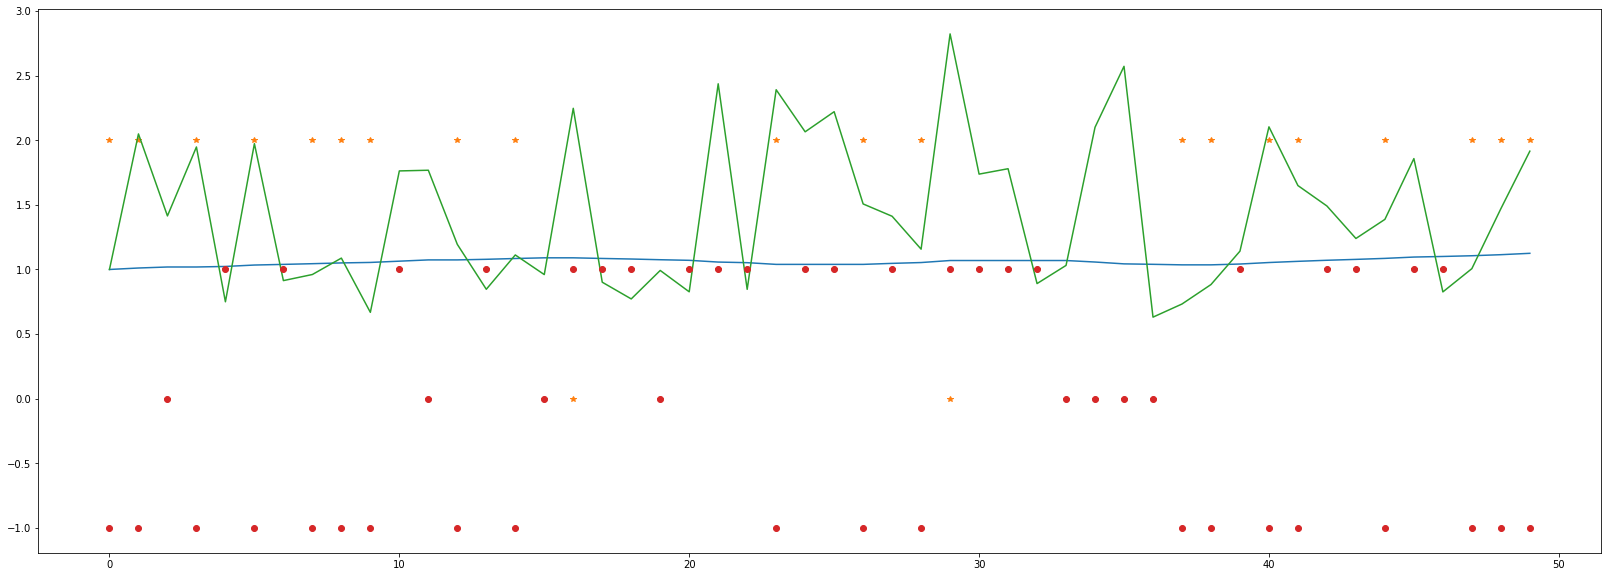

In [0]:
plt.figure(figsize=(28,10))
plt.plot(compute_portvals(x_test3[-50:], y_pred[-50:])/100000)
plt.plot(y_pred[-50:],"*")
plt.plot(x_test3[-50:,-1,3]/x_test[-50,-1,3])
plt.plot(np.array(y_test2[-50:]),"o")

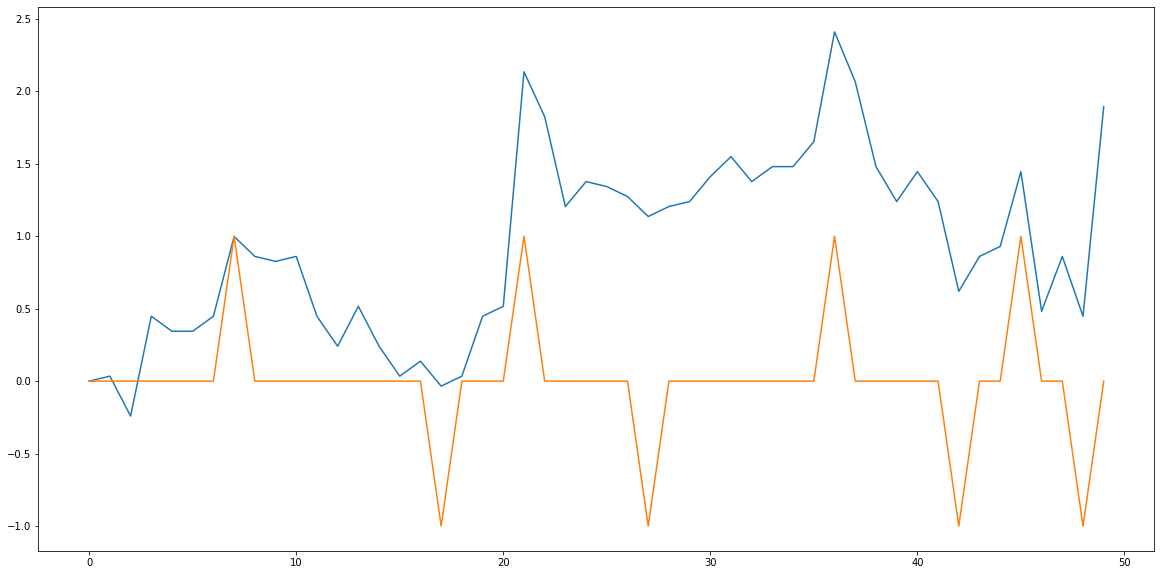

In [0]:
plt.figure(figsize=(20,10))
plt.plot(500*(x_test1[-50:,-1,3]/x_test1[-50,-1,3] - 1))
plt.plot(y_test1[-50:])

In [0]:
np.array(y_test1[-50:])

array([ 0,  0,  0,  0,  0,  0,  1,  0,  0, -1,  0,  0,  0,  1,  0,  0, -1,
        0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1])

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 2, 25, 128)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 25, 256)        33024     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 25, 256)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 25, 256)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1638528   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [0]:
import tensorflow as tf
